In [136]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison, plot_latent
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [137]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

data_train = OwnDataset(train=True, transform=tf)
data_test = OwnDataset(train=False, transform=tf)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)



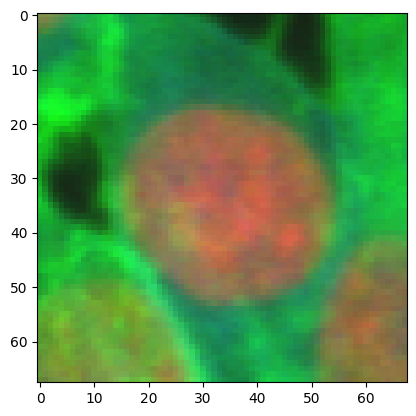

In [138]:
# get a sample image from the dataset
sample = data_train[612][0]

# show the image
show_img(sample.view(3,68,68))


In [139]:
# test to see if the shape is correct

x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 3, 68, 68]) torch.Size([64])


In [140]:
from models import VAE, VAE_LAFARGE
from loss_functions import loss_function

# lafarge cell model from https://proceedings.mlr.press/v102/lafarge19a/lafarge19a.pdf
# class VAE_LAFARGE(VAE):
#     def __init__(self,input_dim, hidden_dim, latent_dim=256):
#         super().__init__()
        
#         # encoder with max pooling and batch normalization
#         self.encoder = nn.Sequential(
#             # block 1
#             nn.Conv2d(3, 32, kernel_size=5), # 68x68x3 -> 64x64x32
#             nn.LeakyReLU(),
#             nn.MaxPool2d(2), # 64x64x32 -> 32x32x32
#             nn.BatchNorm2d(32),

#             # block 2
#             nn.Conv2d(32, 64, kernel_size=5), # 32x32x32 -> 28x28x64
#             nn.LeakyReLU(),
#             nn.MaxPool2d(2), # 28x28x64 -> 14x14x64
#             nn.BatchNorm2d(64),

#             # block 3
#             nn.Conv2d(64, 128, kernel_size=5), # 14x14x64 -> 10x10x128
#             nn.LeakyReLU(),
#             nn.MaxPool2d(2), # 10x10x128 -> 5x5x128
#             nn.BatchNorm2d(128),

#             # block 4
#             nn.Conv2d(128, 256, kernel_size=5), # 5x5x128 -> 1x1x256
#             nn.LeakyReLU(),
#             nn.BatchNorm2d(256),
#             nn.Flatten(),
#             nn.Linear(256, latent_dim*2), # 1x1x256 -> 1x1x512
#             # nn.Sigmoid()
#         )

#         self.mu = nn.Linear(latent_dim*2, latent_dim)
#         self.logvar = nn.Linear(latent_dim*2, latent_dim)

#         # decoder with upsampling and batch normalization turn to 68x68x3 in 4 blocks
#         self.decoder = nn.Sequential(
#             # block 1
#             nn.Unflatten(1, (latent_dim, 1, 1)),
#             nn.ConvTranspose2d(latent_dim, 128, kernel_size=5), # 1x1x256 -> 5x5x128
#             nn.LeakyReLU(),
#             nn.BatchNorm2d(128),
#             nn.Upsample(scale_factor=2), # 5x5x128 -> 10x10x128

#             # block 2
#             nn.ConvTranspose2d(128, 64, kernel_size=5), # 10x10x128 -> 14x14x64
#             nn.LeakyReLU(),
#             nn.BatchNorm2d(64),
#             nn.Upsample(scale_factor=2), # 14x14x64 -> 28x28x64

#             # block 3
#             nn.ConvTranspose2d(64, 32, kernel_size=5), # 28x28x64 -> 32x32x32
#             nn.LeakyReLU(),
#             nn.BatchNorm2d(32),
#             nn.Upsample(scale_factor=2), # 32x32x32 -> 64x64x32
            
#             # block 4
#             nn.ConvTranspose2d(32, 3, kernel_size=5), # 64x64x32 -> 68x68x3
#             # nn.BatchNorm2d(3),
#             nn.Sigmoid()
            
#         )

In [141]:

model = VAE_LAFARGE(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

VAE_LAFARGE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): BatchNorm2d(256, eps=1e-05, mo

In [142]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 3, 68, 68])
x_hat.shape: torch.Size([64, 3, 68, 68])


# Training

In [143]:
num_epochs = 100

train_loss = []
train_mse_loss = []
train_kld_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")




Epoch 1/100, loss: 25797.2765689772, mse: 24173.490221918844, kld: 1623.786231838927
Epoch 2/100, loss: 15917.384386957909, mse: 14214.6351692044, kld: 1702.7491934640068
Epoch 3/100, loss: 23754.347586495536, mse: 15103.832860829878, kld: 8650.514843376315
Epoch 4/100, loss: 14811.638734155771, mse: 12433.56887755102, kld: 2378.0698597187898
Epoch 5/100, loss: 12578.988301179847, mse: 11328.215092873086, kld: 1250.7732107979912
Epoch 6/100, loss: 12321.701964086416, mse: 10986.00743881537, kld: 1335.6945321219307
Epoch 7/100, loss: 12399.79477738361, mse: 10697.365154655612, kld: 1702.4296054450833
Epoch 8/100, loss: 11570.809699856505, mse: 10213.370844626914, kld: 1357.4388203523597
Epoch 9/100, loss: 14810.624417051977, mse: 11304.018775161432, kld: 3506.605611995775
Epoch 10/100, loss: 11066.56197933275, mse: 9840.359315210459, kld: 1226.2026748657227
Epoch 11/100, loss: 10642.683322205836, mse: 9370.835697096221, kld: 1271.8476531359613
Epoch 12/100, loss: 10350.599004005899, mse